# Machine learning Model for Identification of Offensive Language in Tweets
###

#### IMPORTING LIBRARIES AND NECESSARY UTILITIES

In [31]:
import warnings
import re
import numpy as np
import pandas as pd
import string
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
warnings.simplefilter('ignore')

nltk.download('stopwords')
nltk.download('punkt')

stopwords_eng = nltk.corpus.stopwords.words('english')
punctuations = string.punctuation
#from nltk.corpus import stopwords and punctuations

wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
#from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to C:\Users\NICY
[nltk_data]     SCARIA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\NICY
[nltk_data]     SCARIA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Creation of DataFrame

In [2]:


#Customizing the characters seen in the data frame to 100
pd.set_option('display.max_colwidth', 100)
# Creating a DataFrame
tweet_df = pd.read_csv('training_olid.tsv',sep='\t', usecols=['id', 'tweet', 'subtask_a'])
tweet_df.columns = ['ID', 'ORIGINAL_TWEET', 'LABEL']
tweet_df.head()

,ID,ORIGINAL_TWEET,LABEL
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers l...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT


# #Data Exploration

In [3]:
tweet_df.shape
tweet_df.groupby('LABEL').ID.count()

LABEL
NOT    8840
OFF    4400
Name: ID, dtype: int64

In [4]:
#checking for null values in the tweet column
print(tweet_df['ORIGINAL_TWEET'].isnull().sum())

0


<Axes: xlabel='LABEL', ylabel='count'>

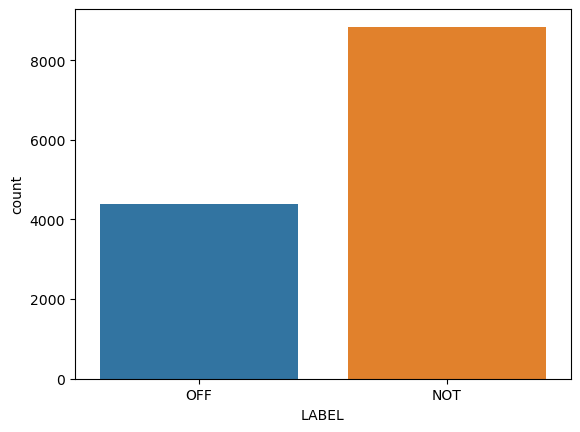

In [5]:
sns.countplot(data=tweet_df, x='LABEL')

# #DATA PREPROCESSING

### Selecting the required columns in the dataframe 

In [6]:
####Preprocessing the created dataframe

#Selecting the label and tweet column for our further analysis
tweet_df=tweet_df[['ORIGINAL_TWEET','LABEL']]
tweet_df['LABEL'].unique()
tweet_df

,ORIGINAL_TWEET,LABEL
0,@USER She should ask a few native Americans what their take on this is.,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF
2,Amazon is investigating Chinese employees who are selling internal data to third-party sellers l...,NOT
3,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF
4,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT
...,...,...
13235,@USER Sometimes I get strong vibes from people and this man’s vibe is tens of millions of murder...,OFF
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too shabby of a summer,NOT
13237,@USER And why report this garbage. We don't give a crap.,OFF
13238,@USER Pussy,OFF


### Data Cleaning

####  Changing categorical values in label column to numerical values 

In [7]:
# Replacing the categorical values for easy understanding. (Assigning 1 and 0 to offensive and not offensive tweets respectively)
tweet_df['LABEL'] = tweet_df['LABEL'].replace('OFF',1)
tweet_df['LABEL'] = tweet_df['LABEL'].replace('NOT',0)

# Printing unique values of label variables
tweet_df['LABEL'].unique()
tweet_df

,ORIGINAL_TWEET,LABEL
0,@USER She should ask a few native Americans what their take on this is.,1
1,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,1
2,Amazon is investigating Chinese employees who are selling internal data to third-party sellers l...,0
3,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",1
4,@USER @USER Obama wanted liberals &amp; illegals to move into red states,0
...,...,...
13235,@USER Sometimes I get strong vibes from people and this man’s vibe is tens of millions of murder...,1
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too shabby of a summer,0
13237,@USER And why report this garbage. We don't give a crap.,1
13238,@USER Pussy,1


#### Normalization of Text in the Column 'Label'

In [8]:
#Removing '@USER', 'URL' and numbers from the dataframe
tweet_df['TWEET']=tweet_df['ORIGINAL_TWEET'].str.replace('@USER', '')
tweet_df['TWEET']=tweet_df['TWEET'].str.replace('URL', '')
tweet_df['TWEET']=tweet_df['TWEET'].str.replace('[0-9]+', '')


####   Data Cleaning, Tokenization, Stopwords removal, Stemming, Lemmatizing

In [9]:
# Cleaning Tweets by defining and calling a function for cleaning text

def data_cleaning(text):
    
    #Removing Punctuations
    text = "".join([char for char in text if char not in punctuations])
    
    #Removing repeating characters
    text = re.sub(r'(.)1+', r'1', text)
    
    #Removing URLs
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
    
    # Tokenization
    text = re.split('\W+', text) #'\W+' regex removes one or more non word characters
    
    # Stopwords removal 
    text = [word for word in text if word.lower() not in stopwords_eng]
    
    #Stemming tweets
    text = [ps.stem(word) for word in text]
    
    #Lemmatizing tweets
    text = " ".join([word for word in text])
    
    return text

#Using the user defined function on the tweet column and changing its name 
tweet_df['clean_TWEET'] = tweet_df['TWEET'].apply(lambda x: data_cleaning(x))
tweet_df.head()

,ORIGINAL_TWEET,LABEL,TWEET,clean_TWEET
0,@USER She should ask a few native Americans what their take on this is.,1,She should ask a few native Americans what their take on this is.,ask nativ american take
1,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,1,Go home you’re drunk!!! #MAGA #Trump 👊🇺🇸👊,go home drunk maga trump
2,Amazon is investigating Chinese employees who are selling internal data to third-party sellers l...,0,Amazon is investigating Chinese employees who are selling internal data to third-party sellers l...,amazon investig chines employe sell intern data thirdparti seller look edg competit marketplac a...
3,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",1,"Someone should'veTaken"" this piece of shit to a volcano. 😂""",someon shouldvetaken piec shit volcano
4,@USER @USER Obama wanted liberals &amp; illegals to move into red states,0,Obama wanted liberals &amp; illegals to move into red states,obama want liber amp illeg move red state


#### Checking for null values in the cleaned text

In [10]:
print(tweet_df['clean_TWEET'].isnull().sum())

0


#### Using CountVectorizer to extract features of text in the cleaned tweets

In [14]:
#vectorisation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

count_vector = CountVectorizer(analyzer=word_tokenize)
X = count_vector.fit_transform(tweet_df['clean_TWEET'])
print(X.shape)


(13240, 14836)


### Preparation of Dataset

In [15]:
from sklearn.preprocessing import LabelEncoder
leb = LabelEncoder()
y = leb.fit_transform(tweet_df['LABEL'])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)


## Defining and Training Classifiers

### 1. Naive Baye classifier

In [17]:
# Train classifier on the training split
from sklearn.naive_bayes import MultinomialNB

mnbayes_clf = MultinomialNB(force_alpha=True)
mnbayes_clf = mnbayes_clf.fit(X_train, y_train)

In [18]:
# Evaluate performance on the test split
import numpy as np

pred_NB = mnbayes_clf.predict(X_test)
accuracy = np.sum((pred_NB == y_test).astype(int)) / pred_NB.size
print("accuracy: %.4f" % (accuracy))

accuracy: 0.7392


In [19]:
# Precision, Recall, F1-Score
from sklearn.metrics import precision_recall_fscore_support as prfs

p_micro, r_micro, f1_micro, _ = prfs(y_pred=pred_NB, y_true=y_test, average="micro")
print("Micro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_micro, r_micro, f1_micro))

p_macro, r_macro, f1_macro, _ = prfs(y_pred=pred_NB, y_true=y_test, average="macro")
print("Macro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_macro, r_macro, f1_macro))

Micro Evaluation: Precision: 0.7392; Recall: 0.7392; F1-Score: 0.7392
Macro Evaluation: Precision: 0.7019; Recall: 0.6866; F1-Score: 0.6925


In [20]:
# making a Confusion matrix for better understanding of precision
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,pred_NB))
print('\n')
print(classification_report(y_test,pred_NB))

[[2242  433]
 [ 603  694]]


              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2675
           1       0.62      0.54      0.57      1297

    accuracy                           0.74      3972
   macro avg       0.70      0.69      0.69      3972
weighted avg       0.73      0.74      0.73      3972



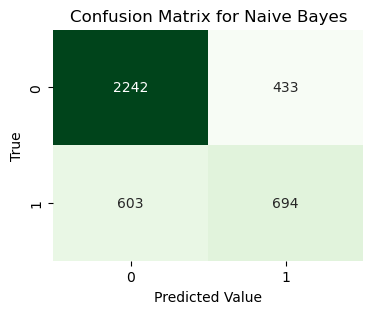

In [21]:
confusion_matrices = confusion_matrix(y_test,pred_NB)


# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrices, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Value")
plt.ylabel("True")
plt.show()

### 2. Logistic Regression Classifier

In [22]:
# Train classifier on the training split
from sklearn.linear_model import LogisticRegression

logreg_clsfier = LogisticRegression(solver="lbfgs", random_state=42, max_iter=1000)

logreg_clsfier = logreg_clsfier.fit(X_train, y_train)

In [23]:
# Evaluate performance on the test split
import numpy as np

pred_LR = logreg_clsfier.predict(X_test)
accuracy = np.sum((pred_LR == y_test).astype(int)) / pred_LR.size
print("accuracy: %.4f" % (accuracy))

accuracy: 0.7727


In [24]:
# Precision, Recall, F1-Score
from sklearn.metrics import precision_recall_fscore_support as prfs

p_micro, r_micro, f1_micro, _ = prfs(y_pred=pred_LR, y_true=y_test, average="micro")
print("Micro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_micro, r_micro, f1_micro))

p_macro, r_macro, f1_macro, _ = prfs(y_pred=pred_LR, y_true=y_test, average="macro")
print("Macro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_macro, r_macro, f1_macro))

Micro Evaluation: Precision: 0.7727; Recall: 0.7727; F1-Score: 0.7727
Macro Evaluation: Precision: 0.7498; Recall: 0.7079; F1-Score: 0.7204


In [25]:
#Cross-validation for performance evaluation and model selection
from sklearn.model_selection import cross_val_score
import random
import numpy as np
np.random.seed(42)
random.seed(32)

scores = cross_val_score(logreg_clsfier, X, y, cv=5, scoring="f1_macro")
print(scores)
print(scores.mean())

[0.70990233 0.71243712 0.72263827 0.70575631 0.73161448]
0.7164697022762007


In [26]:
#Use GridSearchCV for model selection
from sklearn.model_selection import GridSearchCV

logregn_l1_parameter_grid = {
    "C": np.logspace(-2, 1, 100),
    "penalty": [
        # 'l1',
        'l2',
        # 'elasticnet'
        # None,
    ]
}

logreg_clsfier = LogisticRegression(solver="lbfgs", random_state=42, max_iter=1000)

# meta_clf_gridcv = GridSearchCV(logreg_clf, logreg_l1_param_grid, scoring="f1_macro", verbose=1)
logregn_grid_cv = GridSearchCV(logreg_clsfier, logregn_l1_parameter_grid, scoring="f1_macro", verbose=3)
logregn_grid_cv.fit(X_train, y_train)
import sys
# save all GridSearchCV results
print("logregn_grid_cv.best_params_: ", file=sys.stdout)
print(logregn_grid_cv.best_params_, file=sys.stdout)
print("logregn_grid_cv.best_score_: ", file=sys.stdout)
print(logregn_grid_cv.best_score_, file=sys.stdout)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.498 total time=   0.2s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.497 total time=   0.0s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.482 total time=   0.0s
[CV 4/5] END ................C=0.01, penalty=l2;, score=0.485 total time=   0.0s
[CV 5/5] END ................C=0.01, penalty=l2;, score=0.495 total time=   0.1s
[CV 1/5] END C=0.010722672220103232, penalty=l2;, score=0.505 total time=   0.1s
[CV 2/5] END C=0.010722672220103232, penalty=l2;, score=0.513 total time=   0.2s
[CV 3/5] END C=0.010722672220103232, penalty=l2;, score=0.489 total time=   0.1s
[CV 4/5] END C=0.010722672220103232, penalty=l2;, score=0.489 total time=   0.1s
[CV 5/5] END C=0.010722672220103232, penalty=l2;, score=0.503 total time=   0.1s
[CV 1/5] END C=0.011497569953977356, penalty=l2;, score=0.516 total time=   0.1s
[CV 2/5] END C=0.011497569953977356, penalty=l

[CV 2/5] END C=0.040370172585965536, penalty=l2;, score=0.610 total time=   0.1s
[CV 3/5] END C=0.040370172585965536, penalty=l2;, score=0.617 total time=   0.1s
[CV 4/5] END C=0.040370172585965536, penalty=l2;, score=0.625 total time=   0.1s
[CV 5/5] END C=0.040370172585965536, penalty=l2;, score=0.610 total time=   0.3s
[CV 1/5] END .C=0.04328761281083057, penalty=l2;, score=0.613 total time=   0.1s
[CV 2/5] END .C=0.04328761281083057, penalty=l2;, score=0.619 total time=   0.1s
[CV 3/5] END .C=0.04328761281083057, penalty=l2;, score=0.619 total time=   0.1s
[CV 4/5] END .C=0.04328761281083057, penalty=l2;, score=0.626 total time=   0.1s
[CV 5/5] END .C=0.04328761281083057, penalty=l2;, score=0.614 total time=   0.1s
[CV 1/5] END C=0.046415888336127795, penalty=l2;, score=0.617 total time=   0.1s
[CV 2/5] END C=0.046415888336127795, penalty=l2;, score=0.625 total time=   0.3s
[CV 3/5] END C=0.046415888336127795, penalty=l2;, score=0.625 total time=   0.1s
[CV 4/5] END C=0.04641588833

[CV 4/5] END .C=0.16297508346206444, penalty=l2;, score=0.695 total time=   0.2s
[CV 5/5] END .C=0.16297508346206444, penalty=l2;, score=0.676 total time=   0.3s
[CV 1/5] END .C=0.17475284000076838, penalty=l2;, score=0.663 total time=   0.3s
[CV 2/5] END .C=0.17475284000076838, penalty=l2;, score=0.678 total time=   0.2s
[CV 3/5] END .C=0.17475284000076838, penalty=l2;, score=0.675 total time=   0.2s
[CV 4/5] END .C=0.17475284000076838, penalty=l2;, score=0.699 total time=   0.4s
[CV 5/5] END .C=0.17475284000076838, penalty=l2;, score=0.679 total time=   0.3s
[CV 1/5] END ..C=0.1873817422860384, penalty=l2;, score=0.665 total time=   0.2s
[CV 2/5] END ..C=0.1873817422860384, penalty=l2;, score=0.678 total time=   0.4s
[CV 3/5] END ..C=0.1873817422860384, penalty=l2;, score=0.679 total time=   0.3s
[CV 4/5] END ..C=0.1873817422860384, penalty=l2;, score=0.697 total time=   0.3s
[CV 5/5] END ..C=0.1873817422860384, penalty=l2;, score=0.680 total time=   0.4s
[CV 1/5] END .C=0.2009233002

[CV 1/5] END ..C=0.7054802310718645, penalty=l2;, score=0.694 total time=   0.6s
[CV 2/5] END ..C=0.7054802310718645, penalty=l2;, score=0.697 total time=   0.4s
[CV 3/5] END ..C=0.7054802310718645, penalty=l2;, score=0.697 total time=   0.5s
[CV 4/5] END ..C=0.7054802310718645, penalty=l2;, score=0.717 total time=   0.4s
[CV 5/5] END ..C=0.7054802310718645, penalty=l2;, score=0.697 total time=   0.5s
[CV 1/5] END ..C=0.7564633275546291, penalty=l2;, score=0.695 total time=   0.5s
[CV 2/5] END ..C=0.7564633275546291, penalty=l2;, score=0.697 total time=   0.5s
[CV 3/5] END ..C=0.7564633275546291, penalty=l2;, score=0.698 total time=   0.6s
[CV 4/5] END ..C=0.7564633275546291, penalty=l2;, score=0.718 total time=   0.5s
[CV 5/5] END ..C=0.7564633275546291, penalty=l2;, score=0.697 total time=   0.4s
[CV 1/5] END ..C=0.8111308307896873, penalty=l2;, score=0.695 total time=   0.5s
[CV 2/5] END ..C=0.8111308307896873, penalty=l2;, score=0.700 total time=   0.5s
[CV 3/5] END ..C=0.811130830

[CV 3/5] END ...C=2.848035868435802, penalty=l2;, score=0.698 total time=   0.9s
[CV 4/5] END ...C=2.848035868435802, penalty=l2;, score=0.721 total time=   0.9s
[CV 5/5] END ...C=2.848035868435802, penalty=l2;, score=0.696 total time=   0.9s
[CV 1/5] END ..C=3.0538555088334154, penalty=l2;, score=0.696 total time=   0.9s
[CV 2/5] END ..C=3.0538555088334154, penalty=l2;, score=0.696 total time=   0.8s
[CV 3/5] END ..C=3.0538555088334154, penalty=l2;, score=0.697 total time=   0.8s
[CV 4/5] END ..C=3.0538555088334154, penalty=l2;, score=0.726 total time=   0.9s
[CV 5/5] END ..C=3.0538555088334154, penalty=l2;, score=0.697 total time=   0.9s
[CV 1/5] END ..C=3.2745491628777286, penalty=l2;, score=0.697 total time=   1.1s
[CV 2/5] END ..C=3.2745491628777286, penalty=l2;, score=0.693 total time=   0.8s
[CV 3/5] END ..C=3.2745491628777286, penalty=l2;, score=0.697 total time=   0.9s
[CV 4/5] END ..C=3.2745491628777286, penalty=l2;, score=0.728 total time=   0.9s
[CV 5/5] END ..C=3.274549162

In [27]:
best_logreg_clsfier = logregn_grid_cv.best_estimator_
logreg_clsfier = best_logreg_clsfier.fit(X_train, y_train)

In [28]:
#Using the best estimator that is retrained on the whole training split dataset
pred_LR = logreg_clsfier.predict(X_test)

from sklearn.metrics import precision_recall_fscore_support as prfs

p_micro, r_micro, f1_micro, _ = prfs(y_pred=pred_LR, y_true=y_test, average="micro")
print("Micro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_micro, r_micro, f1_micro))

p_macro, r_macro, f1_macro, _ = prfs(y_pred=pred_LR, y_true=y_test, average="macro")
print("Macro Evaluation: Precision: %.4f; Recall: %.4f; F1-Score: %.4f" % (p_macro, r_macro, f1_macro))

Micro Evaluation: Precision: 0.7661; Recall: 0.7661; F1-Score: 0.7661
Macro Evaluation: Precision: 0.7383; Recall: 0.7060; F1-Score: 0.7165


In [29]:
# making a Confusion matrix for better understanding of precision
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,pred_LR))
print('\n')
print(classification_report(y_test,pred_LR))

[[2352  323]
 [ 606  691]]


              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2675
           1       0.68      0.53      0.60      1297

    accuracy                           0.77      3972
   macro avg       0.74      0.71      0.72      3972
weighted avg       0.76      0.77      0.76      3972



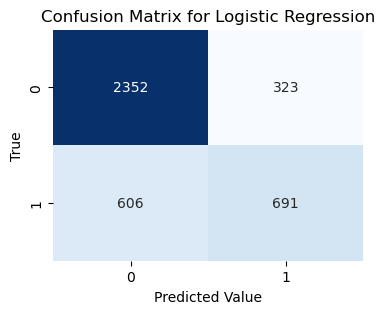

In [30]:
confusion_matrices = confusion_matrix(y_test,pred_LR)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrices, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Value")
plt.ylabel("True")
plt.show()